## 链式法则

In [1]:
import tensorflow as tf 

# 构建待优化变量
x = tf.constant(1.)
w1 = tf.constant(2.)
b1 = tf.constant(1.)
w2 = tf.constant(2.)
b2 = tf.constant(1.)


with tf.GradientTape(persistent=True) as tape:
    # 非tf.Variable类型的张量需要人为设置记录梯度信息
    tape.watch([w1, b1, w2, b2])
    # 构建2层网络
    y1 = x * w1 + b1
    y2 = y1 * w2 + b2

# 独立求解出各个导数
dy2_dy1 = tape.gradient(y2, [y1])[0]
dy1_dw1 = tape.gradient(y1, [w1])[0]
dy2_dw1 = tape.gradient(y2, [w1])[0]

# 验证链式法则
print(dy2_dy1 * dy1_dw1)
print(dy2_dw1)

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


## Himmelblau 函数优化实战
Himmelblau 函数是用来测试优化算法的常用样例函数之一，它包含了两个自变量𝑥和
𝑦，数学表达式是：  
$𝑓(𝑥, 𝑦) = (𝑥^2 + 𝑦 − 11)^2 + (𝑥 + 𝑦^2 − 7)^2$

In [2]:
def himmelblau(x,y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

(120,) (120,)
(120, 120) (120, 120)


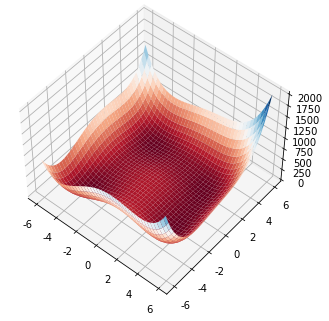

In [3]:
import numpy as np
x = np.arange(-6, 6, 0.1) 
y = np.arange(-6, 6, 0.1) 
print(x.shape, y.shape)
x,y = np.meshgrid(x, y)
print(x.shape, y.shape)
z = himmelblau(x,y) 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.unicode_minus']=False
pl = plt.figure('himmelblau')
ax=Axes3D(pl,auto_add_to_figure=False)
pl.add_axes(ax)
ax.plot_surface(x, y, z,cmap=plt.get_cmap('RdBu'))
ax.view_init(50., -50)
plt.show()

我们可以通过解析的方法计算出局部极小值的精确坐标，它们分别是：  
(3,2), (−2.805, 3.131), (−3.779, −3.283), (3.584, −1.848)  
在已经知晓极值解析解的情况下，我们现在利用梯度下降算法来优化 Himmelblau 函数的极小值数值解.

In [4]:
import tensorflow as tf
x = tf.constant(4.)
y= tf.constant(0.)
for step in range(200):
    with tf.GradientTape() as tape: 
        tape.watch([x,y]) 
        z = himmelblau(x,y)
        grads = tape.gradient(z, [x,y]) 
        x -= 0.01*grads[0]
        y -= 0.01*grads[1]
    if step % 20 == 19:
        print ('step {}: x = {},y={}, f(x) = {}'.format(step, x.numpy(), y.numpy(),z.numpy()))

step 19: x = 3.538121461868286,y=-1.3465766906738281, f(x) = 3.7151756286621094
step 39: x = 3.5843276977539062,y=-1.8470240831375122, f(x) = 3.4506843803683296e-05
step 59: x = 3.584428071975708,y=-1.8481253385543823, f(x) = 4.206412995699793e-11
step 79: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 99: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 119: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 139: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 159: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 179: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13
step 199: x = 3.584428310394287,y=-1.8481264114379883, f(x) = 2.2737367544323206e-13


这与解析解之一(3.584, −1.848)几乎一样。  
实际上，通过改变网络参数的初始化状态，程序可以得到多种极小值数值解。参数的初始化状态是可能影响梯度下降算法的搜索轨迹的，甚至有可能搜索出完全不同的数值解.

## 反向传播实战

[[-0.12334611  0.47982802]
 [ 0.30949881 -0.12081774]
 [-0.25131072  0.78384564]
 ...
 [ 1.88761447 -0.04108802]
 [-0.66517129  0.47265569]
 [ 0.99069928 -0.58254681]]
(2000, 2)
[1 1 1 ... 1 0 1]
(2000,)


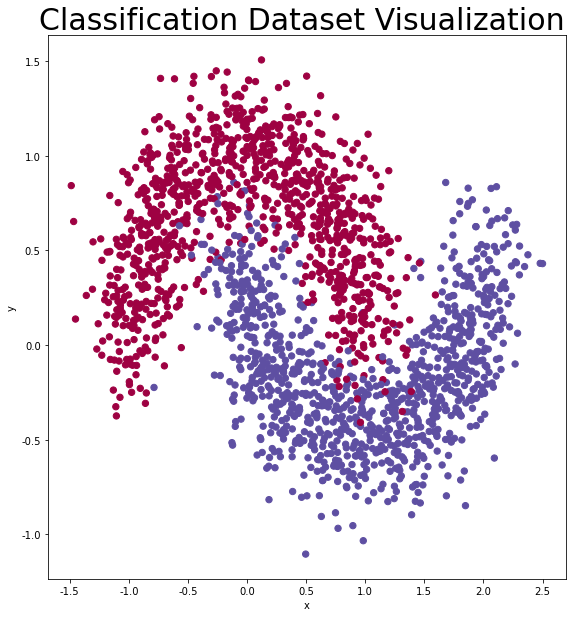

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x, y = make_moons(n_samples = 2000, noise=0.2, random_state=100) 
print(x)
print(x.shape)
print(y)
print(y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

def make_plot(x, y, plot_name):
    plt.figure(figsize=(12,10))
    axes = plt.gca()
    axes.set(xlabel="x", ylabel="y")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral)
    # cmap = plt.cm.Spectral实现的功能是给label为1的点一种颜色，给label为0的点另一种颜色。
    plt.show()
    plt.close()

make_plot(x, y, "Classification Dataset Visualization ")

In [6]:
class Layer:
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        
        """
        :param int n_input: 输入节点数
        :param int n_neurons: 输出节点数
        :param str activation: 激活函数类型
        :param weights: 权值张量，默认类内部生成
        :param bias: 偏置，默认类内部生成
        """
        
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation
        self.last_activation = None 
        self.error = None 
        self.delta = None 
    
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias # X@W+b
        self.last_activation = self._apply_activation(r)
        return self.last_activation
    
    def _apply_activation(self, r):
        if self.activation is None:
            return r 
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r
    
    def apply_activation_derivative(self, r):
        if self.activation is None:
            return np.ones_like(r)
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        elif self.activation == 'tanh':
            return 1 - r ** 2
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r

In [7]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []
        
    def add_layer(self, layer):
        self._layers.append(layer)
        
    def feed_forward(self, x):
        for layer in self._layers:
            x = layer.activate(x)
        return x
    
    def backpropagation(self, x, y, learning_rate):
        output = self.feed_forward(x)
        
        for i in reversed(range(len(self._layers))): 
            layer = self._layers[i] 

            if layer == self._layers[-1]: 
                layer.error = y - output 
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: 
                next_layer = self._layers[i + 1] 
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)

        for i in range(len(self._layers)):
            layer = self._layers[i]
            o_i = np.atleast_2d(x if i == 0 else self._layers[i -1].last_activation)
            layer.weights += layer.delta * o_i.T * learning_rate
            
    def train(self, x_train, x_test, y_train, y_test, learning_rate, max_epochs):
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = []
        accuracies=[]
        for i in range(max_epochs):
            for j in range(len(x_train)): 
                self.backpropagation(x_train[j], y_onehot[j], learning_rate)
            if i % 10 == 0:
                mse = np.mean(np.square(y_onehot - self.feed_forward(x_train)))
                accuracy=self.accuracy(self.predict(x_test), y_test)
                mses.append(mse)
                accuracies.append(accuracy)
                print('Epoch: %s, MSE: %f' % (i, float(mse)))
                print('Accuracy: %.2f%%' % (accuracy * 100))
        return mses,accuracies
    
    def predict(self, x):
        return self.feed_forward(x)

    def accuracy(self, x, y):
        return np.sum(np.equal(np.argmax(x, axis=1), y)) / y.shape[0]

In [8]:
nn = NeuralNetwork() 
nn.add_layer(Layer(2, 25, 'sigmoid')) 
nn.add_layer(Layer(25, 50, 'sigmoid')) 
nn.add_layer(Layer(50, 25, 'sigmoid')) 
nn.add_layer(Layer(25, 2, 'sigmoid')) 

In [9]:
mses,accuracies=nn.train(x_train, x_test, y_train, y_test, 0.001, 200)

Epoch: 0, MSE: 0.271123
Accuracy: 50.50%
Epoch: 10, MSE: 0.248885
Accuracy: 69.00%
Epoch: 20, MSE: 0.246680
Accuracy: 74.33%
Epoch: 30, MSE: 0.244100
Accuracy: 76.33%
Epoch: 40, MSE: 0.240803
Accuracy: 76.33%
Epoch: 50, MSE: 0.236287
Accuracy: 77.50%
Epoch: 60, MSE: 0.229791
Accuracy: 78.33%
Epoch: 70, MSE: 0.220208
Accuracy: 79.00%
Epoch: 80, MSE: 0.206294
Accuracy: 79.00%
Epoch: 90, MSE: 0.187828
Accuracy: 79.33%
Epoch: 100, MSE: 0.167542
Accuracy: 79.83%
Epoch: 110, MSE: 0.150012
Accuracy: 80.67%
Epoch: 120, MSE: 0.137245
Accuracy: 82.17%
Epoch: 130, MSE: 0.128270
Accuracy: 83.50%
Epoch: 140, MSE: 0.121626
Accuracy: 84.33%
Epoch: 150, MSE: 0.116391
Accuracy: 85.00%
Epoch: 160, MSE: 0.112111
Accuracy: 85.67%
Epoch: 170, MSE: 0.108581
Accuracy: 86.17%
Epoch: 180, MSE: 0.105699
Accuracy: 86.17%
Epoch: 190, MSE: 0.103396
Accuracy: 87.17%


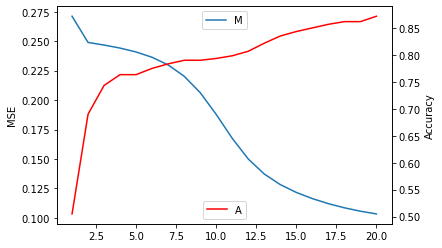

In [10]:
pl = plt.figure()
ax1 = pl.add_subplot(111)
ax1.plot(range(1,21),mses)
ax1.set_ylabel('MSE')
ax2 = ax1.twinx()
ax2.plot(range(1,21),accuracies, 'r')
ax2.set_ylabel('Accuracy')
ax1.legend('MSE',loc=9)
ax2.legend('Acc',loc=8)
plt.show()
plt.close()